# COS-method

We offer you the following practical task on the COS-method.

Total score is **110**, which will be converted to $22\%$ of the course grade. You have $1$ month for this work. **Deadline is the 30st of December, 23:59 MSK**.

The file must be sent to **stoch-vol-23-fall@yandex.ru** with topic "stoch-vol Lab2".  Please rename your file as **"SurnameName_Lab2.ipynb"** before sending.

If you have any questions feel free to ask in Telegram in the **group chat**.

**Full name: Suleimanov Askhab**

**Faculty: MSU MMF**

In [ ]:
from copy import deepcopy
from typing import Callable, Union
import math
from dataclasses import dataclass, replace, is_dataclass

import numpy as np
import numpy.typing as npt
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

!pip install py_vollib
from py_vollib.black_scholes.implied_volatility import implied_volatility



  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 4.4 MB/s eta 0:00:00
  Created wheel for py_vollib: filename=py_vollib-1.0.1-py3-none-any.whl size=62829 sha256=42d600797f6910508e14bb688eba2e35a10bf66ec8826b7654606317445639c8
  Stored in directory: /root/.cache/pip/wheels/84/0c/fc/b68506eda40cccaeb0013be550ba904d253ec90eae2b156052
  Created wheel for py_lets_be_rational: filename=py_lets_be_rational-1.0.1-py3-none-any.whl size=24451 sha256=dcb5ca5d4502921fe594b46b78c0154d1c7d222be75de4f549b65a072c7891c8
  Stored in directory: /root/.cache/pip/wheels/32/d9/4f/360d4b0b9ec7c65583ec7c8e72fd2158c97ad04fbcb932891c
Successfully built py_vollib py_lets_be_rational


/usr/local/lib/python3.10/dist-packages/py_lets_be_rational/numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


In [ ]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

In [ ]:
implied_volatility_vec = np.vectorize(implied_volatility)

In [ ]:
ZONE              = ZoneInfo("Europe/Moscow")
ASSIGNMENT_DT     = datetime(2023, 12, 2, 23, 45, 0, tzinfo=ZONE)
NO_PENALTY_PERIOD = timedelta(days=14)
HARD_DEADLINE     = datetime(2023, 12, 30, 23, 59, 59, tzinfo=ZONE)

NameError: ignored

In [ ]:
def get_score_multiplier(lab_hand_dt: datetime = datetime.now().astimezone()) -> float:
    """Calculate overeall lab score multiplier.

    The function calculates the lab score weighting factor, based on time,
    when the solved lab was handed in. The factor equals 1 during the
    `NO_PENALTY_PERIOD` starting at the `ASSIGNMENT_DT, then lineary decays
    towards 0 by the `HARD_DEADLINE`date.

    Args:
        lab_hand_dt: datetime when the lab is handed in. Now by default. Must be
        timezone-aware.

    Returns:
        A factor between 0 and 1, by which the final score will be multiplied.
    """
    assert lab_hand_dt.tzinfo is not None,\
        "The argument must be timezone-aware. Use `datetime.astimezone()` "\
        "to use your local timezone."

    if lab_hand_dt < ASSIGNMENT_DT + NO_PENALTY_PERIOD:
        return 1.

    decay_period = HARD_DEADLINE - ASSIGNMENT_DT - NO_PENALTY_PERIOD
    elapsed_with_penalty = lab_hand_dt - ASSIGNMENT_DT - NO_PENALTY_PERIOD
    factor = 1. - elapsed_with_penalty.total_seconds() / decay_period.total_seconds()
    return max(0., factor)

NameError: ignored

In [ ]:
HAND_IN_DT = ...
LAB_SCORE = ...
print(f"Final score is {int(LAB_SCORE * get_score_multiplier(HAND_IN_DT))}")

# Episode 1: pricing with COS-method (50 points)

In [ ]:
FloatArray = npt.NDArray[np.float_]
Floats = Union[float, FloatArray]

@dataclass
class MarketState:
    stock_price: Floats
    interest_rate: Floats
    time: Floats = 0

@dataclass
class HestonParams:
    v: float # initial variance V_0
    kappa: float # speed of mean-reversion
    theta: float # long-term mean
    sigma: float # vol of vol
    rho: float # correlation between brownian motions

@dataclass
class StockOption:
    strike_price: Floats
    expiration_time: Floats  # in years
    is_call: Union[bool, npt.NDArray[np.bool_]] = None

    def __post_init__(self):
        assert self.is_call is not None

    def payoff(self, stock_price: Floats) -> Floats:
        call_payoff = np.maximum(0, stock_price - self.strike_price)
        put_payoff = np.maximum(0, self.strike_price - stock_price)
        return np.where(self.is_call, call_payoff, put_payoff)

class CallStockOption(StockOption):
    def __post_init__(self):
        self.is_call = True

class PutStockOption(StockOption):
    def __post_init__(self):
        self.is_call = False

In [ ]:
def heston_log_char_func(omega: Floats,
                         dt: Floats,
                         p: HestonParams) -> Floats:
    """Computes the logarithm og the Heston characteristic function assuming the stock
    trades at 1 and no drift.

    To recover the CF if the stock trades at s multiply by the factor
    exp(i omega (log(s) + \mu dt)) the exponent of the result.

    Args:
        omega: frequency dual to the price domain
        dt: time to evaluate CF at
        p: model parameters

    Returns:
        float: log characteristic function value
    """
    D = np.sqrt(
        (p.kappa - 1j * p.rho * p.sigma * omega) ** 2
        + (omega ** 2 + 1j * omega) * p.sigma ** 2
    )
    F = p.kappa - 1j * p.rho * p.sigma * omega - D
    G = F / (F + 2 * D)
    df = np.exp(-D * dt)  # discount factor
    return (
        p.v / p.sigma ** 2 * (1 - df) / (1 - G * df) * F
        + p.kappa * p.theta / p.sigma ** 2 * (
            dt * F - 2 * np.log((1 - G * df) / (1 - G))

          )
    )

## Implement coefficients for vanilla put

In [ ]:
a = np.array([1.0, 2.0, 3.0])
b = np.array([2.0, 2.0, 2.0])

a * b.T

array([2., 4., 6.])

In [ ]:
def Chi(c: int, d: int, k: Floats, a: int, b: int) -> Floats:
  return ( (1/(1 + ((k * np.pi)/(b - a))**2) )* (np.cos((k * np.pi * (d - a))/(b - a)) * np.exp(d) -
          np.cos((k * np.pi * (c - a))/(b - a)) * np.exp(c) +
          ((k * np.pi)/(b - a)) * np.sin((k * np.pi * (d - a))/(b - a)) * np.exp(d) -
          ((k * np.pi)/(b - a)) * np.sin((k * np.pi * (c - a))/(b - a)) * np.exp(c)) )

def Psi(c: int, d: int, k: Floats, a: int, b: int) -> Floats:
  k[0] = 1
  arr =   ((b - a)/(k * np.pi) ) * (np.sin((k * np.pi * (d - a))/(b - a)) -
    np.sin((k * np.pi * (c - a))/(b - a)) )

  arr[0] = d - c

  return arr





def vanilla_put_cos_expansion_coeffs(a: Floats,
                                     b: Floats,
                                     k: int) -> Floats:
    """
    Computes the cosine expansion coefficients of the vanilla put option
    payoff.

    Args:
        a, b: integration bounds for the payoff function
        k: number of coefficients

    Returns:
        vector of coefficients
    """
    assert np.shape(a) == np.shape(b)

    res = list([])

    k_ = np.arange(0, k, 1)


    if(np.issubdtype(type(a), int) or np.issubdtype(type(a), float)):
      res.append(( (2/(b - a)) * (Psi(a, 0, k_, a, b) - Chi(a, 0, k_, a, b))))

      res[0][0] = 2 * (np.exp(a) - 1 - a)/(b - a)

      assert np.shape(res) ==  (1, k)
      return res


    for i in range(0, len(a)):
      res.append(( (2/(b[i] - a[i])) * (Psi(a[i], 0, k_, a[i], b[i]) - Chi(a[i], 0, k_, a[i], b[i]))))
      res[i][0] = 2 * (np.exp(a[i]) - 1 - a[i])/(b[i] - a[i])

    # print(np.shape(res), (*np.shape(a), k))
    assert np.shape(res) == (*np.shape(a), k)  # hint for proper vectorization

    return res

## Implement the COS method

For now use the following stub to calculate the truncation range

In [ ]:
def calc_trunc_range(eps: float, params: HestonParams, dt: float):
    return -1000, 1000


In [ ]:
# Из статьи Фанга. [c1 - 12 * sqrt(|c2|), c1 + 12 * sqrt(|c2|)]

def Cumulant_1(params: HestonParams, dt: float):
  return ( ms.interest_rate * dt + (1 - np.exp(-params.kappa * dt)) * (params.theta - params.v)/(2 * params.kappa) - 0.5 * params.theta * dt )

def Cumulant_2(params: HestonParams, dt: float):
  a1 = params.sigma * dt * params.kappa * np.exp(-params.kappa * dt) * (params.v - params.theta) * (8 * params.kappa * params.rho - 4 * params.sigma)
  a2 = params.kappa * params.sigma * params.rho * (1 - np.exp(-params.kappa * dt)) * (16 * params.theta - 8 * params.v)
  a3 = 2 * params.theta * params.kappa * dt * (-4 * params.kappa * params.rho * params.sigma + (params.sigma)**2 + 4 * (params.kappa)**2)
  a4 = ((params.sigma)**2) * ((params.theta - 2 * params.v) * np.exp(-2 * params.kappa * dt) + params.theta * (6 * np.exp(-params.kappa * dt) - 7) + 2 * params.v)
  a5 = 8 * ((params.kappa)**2) * (params.v - params.theta) * (1 - np.exp(-params.kappa * dt))
  return (a1 + a2 + a3 + a4 + a5)/(8 * (params.kappa)**3)



def trunc_range(params: HestonParams, dt: float):
  c1 = Cumulant_1(params, dt)
  c2 = Cumulant_2(params, dt)
  return c1 - 12 * np.sqrt(np.abs(c2)), c1 + 12 * np.sqrt(np.abs(c2))

In [ ]:
def Phi(omega: Floats, dt: Floats, p: HestonParams, ms: MarketState, option: StockOption) -> Floats:

  part = heston_log_char_func(omega, dt, p)

  print(" part = ", np.shape(part))

  return (np.exp(part)) # + 1j * omega * np.log(ms.stock_price)) )


In [ ]:
# Подсчет суммы для расчета COS метододом стоимости опциона

def Sum( a: int, b: int, N: int, option: StockOption, params: HestonParams, ms: MarketState, dt: Floats):
  n = np.arange(1, N, 1)
  omega = (n * np.pi)/(b - a)

  Strike = option.strike_price

  x = np.log(ms.stock_price / Strike / np.exp(-ms.interest_rate * dt))
  x[x < a] = a
  x[x > b] = b

  #if x < a or x > b:
   # return 0

  q =  (1j * n[:, None] * np.pi * ((x[:, None]).T - a))/(b - a)

  P = Phi(omega, dt, params, ms, option)

  stt = 1j * omega[:, None] * ((np.log(Strike))[:, None]).T
  stt = np.exp(stt)

  print("stt = ", np.shape(stt))

  arr1 = P[:, None] * np.exp(q)

  arr2 = arr1.real

  print(np.shape(arr2))

  zer = np.full(len(Strike), 1/2)

  arrr = np.hstack((zer[:, None], arr2.T))


  V =  vanilla_put_cos_expansion_coeffs(a, b, N) * Strike[:, None]
  #V_0 = (V[0])[:, None] * (Strike[:, None]).T

  #ew_V = np.delete(V, V_0)

#  print(np.shape(V), np.array(arrr))

  arrr = np.array(arrr)
  arr3 = V * arrr
 # print(np.shape(arr3))

  ar = np.sum(arr3, axis=1)
  #print(np.shape(arr3))
  #print(np.shape(ar))

  #print(ar)

  return ar

In [ ]:
# Стоимость опциона

def price(
    option: StockOption,
    ms: MarketState,
    params: HestonParams,
    eps: float = 1e-3,
    n_points: int = 4096,
):
    dt = np.asarray(option.expiration_time - ms.time)
    a, b = trunc_range(params, dt)
    print("a = ", a, " b = ", b)
    N = n_points

    sum = Sum(a, b, N, option, params, ms, dt)



    # don't forget to check the argument to be within the truncation bounds

    # assure that the resulting option price strictly greater than the theoretical
    # price lower bound
    put = np.exp(-ms.interest_rate * dt) * sum
    if option.is_call:
      return put + ms.stock_price - option.strike_price * np.exp(-ms.interest_rate * dt)
    return put

In [ ]:
strikes = np.linspace(40, 200, 15)
time = np.array(1.0)

calls = CallStockOption(strike_price=strikes,
                        expiration_time=time)
puts = PutStockOption(strike_price=strikes,
                      expiration_time=time)

ms = MarketState(stock_price=100, interest_rate=0.05)

params = HestonParams(v=0.1, kappa=2, theta=0.1, sigma=0.7, rho=-0.2)

a =  -3.8664536688579094  b =  3.8664536688579094
 part =  (4095,)
stt =  (4095, 15)
(4095, 15)
a =  -3.8664536688579094  b =  3.8664536688579094
 part =  (4095,)
stt =  (4095, 15)
(4095, 15)


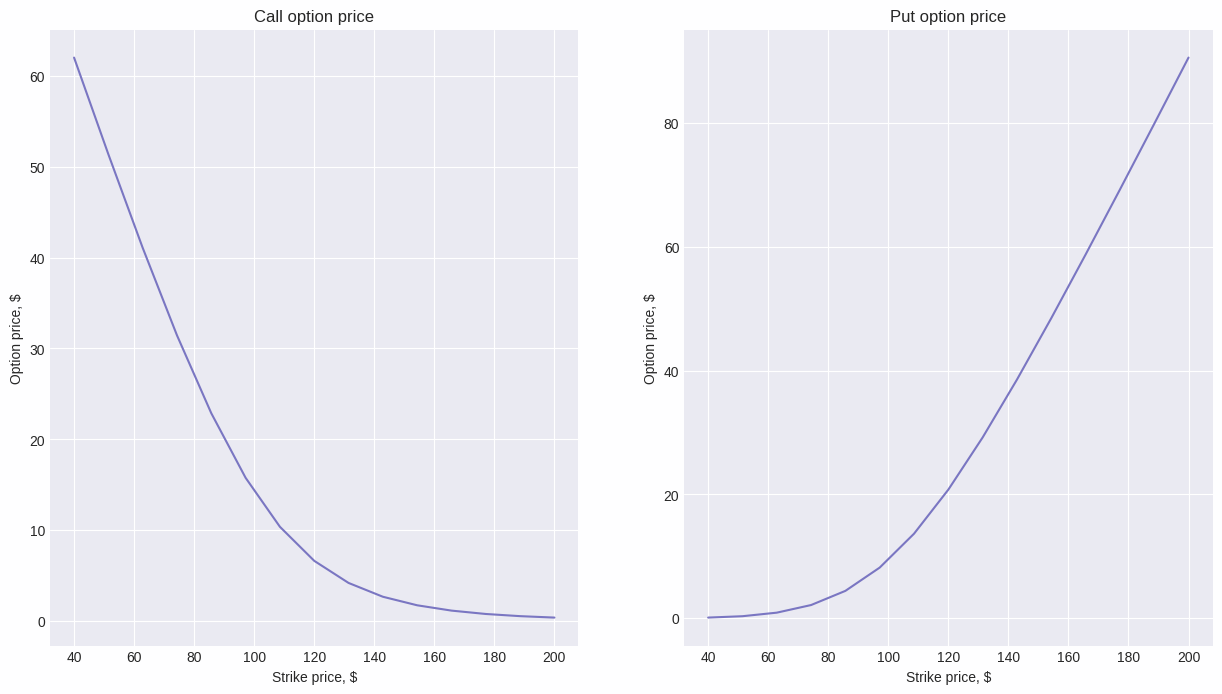

In [ ]:
# Пример выичисления

call_price = price(calls, ms, params)
put_price = price(puts, ms, params)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))

ax1.plot(strikes, call_price)
ax1.set_title('Call option price')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('Option price, $')
#print(strikes)
ax2.plot(strikes, put_price)
ax2.set_title('Put option price')
ax2.set_xlabel('Strike price, $')
ax2.set_ylabel('Option price, $')

plt.show()

# Episode 2: checking with MC (30 points)

implement the `price_mc` function and check the correctness of the imlementation.

In [ ]:
# Для симуляции путей и метода Монте-Карло использую 9 семинар

class BaseHestonSimulState:
    def __init__(
        self,
        params: HestonParams,
        ms: MarketState,
        shape: Union[int, tuple[int]],
    ):
        raise NotImplemented

    @property
    def stock_price(self) -> Floats:
        raise NotImplemented

    def advance(
        self,
        dt: float,
        random: np.random.Generator,
    ):
        raise NotImplemented

In [ ]:
def simulate_heston(
    params: HestonParams,
    initial_simul_state: BaseHestonSimulState,
    time_stop: float = 1.0,
    n_time_steps: int = 100,
    random_seed: int = 0x11A_3AB0D,
    ret_intermediate_states: bool = False,
):
    random = np.random.default_rng(random_seed)
    dt = (time_stop - ms.time) / n_time_steps
    hs = initial_simul_state

    if ret_intermediate_states:
        states = [deepcopy(hs)]

    stock_price = np.empty((*np.shape(initial_simul_state.stock_price), n_time_steps + 1))
    stock_price[:, 0] = initial_simul_state.stock_price

    for i in trange(n_time_steps):
        hs.advance(dt, random)
        stock_price[:, i + 1] = hs.stock_price

        if ret_intermediate_states:
            states.append(deepcopy(hs))

    if ret_intermediate_states:
        return stock_price, states

    return stock_price

In [ ]:
@dataclass
class LogEulerSimulState(BaseHestonSimulState):
    def __init__(
        self,
        params: HestonParams,
        ms: MarketState,
        shape: Union[int, tuple[int]],
    ):
        self._log_stock_price = np.full(shape, np.log(ms.stock_price))
        self._variance = np.full(shape, params.v)
        self._interest_rate = ms.interest_rate
        self._p = params

    @property
    def log_stock_price(self):
        return self._log_stock_price

    @property
    def stock_price(self):
        return np.exp(self._log_stock_price)

    @property
    def variance(self):
        return self._variance

    def advance(
        self,
        dt: float,
        random: np.random.Generator,
    ):
        z1, z2 = random.normal(size=(2, *np.shape(self._log_stock_price)))
        dW_v = z1 * math.sqrt(dt)
        dW_s = math.sqrt(dt) * (self._p.rho * z1 + math.sqrt(1 - self._p.rho**2) * z2)
        new_v = (
            self._variance
            + self._p.kappa * (self._p.theta - self._variance) * dt
            + self._p.sigma * np.sqrt(self._variance) * dW_v
        )
        new_log_s = (
            self._log_stock_price
            + (self._interest_rate - self._variance / 2) * dt
            + np.sqrt(self._variance) * dW_s
        )
        self._log_stock_price = new_log_s
        # self.variance = np.maximum(new_v, 0)
        self._variance = np.where(
            new_v > 0,
            new_v,
            new_v - 2 * self._p.sigma * np.sqrt(self._variance) * dW_v
        )

In [ ]:
N_PATHS = 10
N_STEPS = 100
T = 1.

params = HestonParams(v=0.1, kappa=2, theta=0.1, sigma=0.7, rho=-0.2)
ms = MarketState(stock_price=100.0, interest_rate=0.1, time=0)

hs = LogEulerSimulState(params, ms, N_PATHS)
paths, states = simulate_heston(
    # params,
    replace(params, theta=2000.0),
    hs,
    time_stop=T,
    n_time_steps=N_STEPS,
    ret_intermediate_states=True, )

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
np.isnan(paths).any()

False

In [ ]:
(paths < 0).mean()

0.0

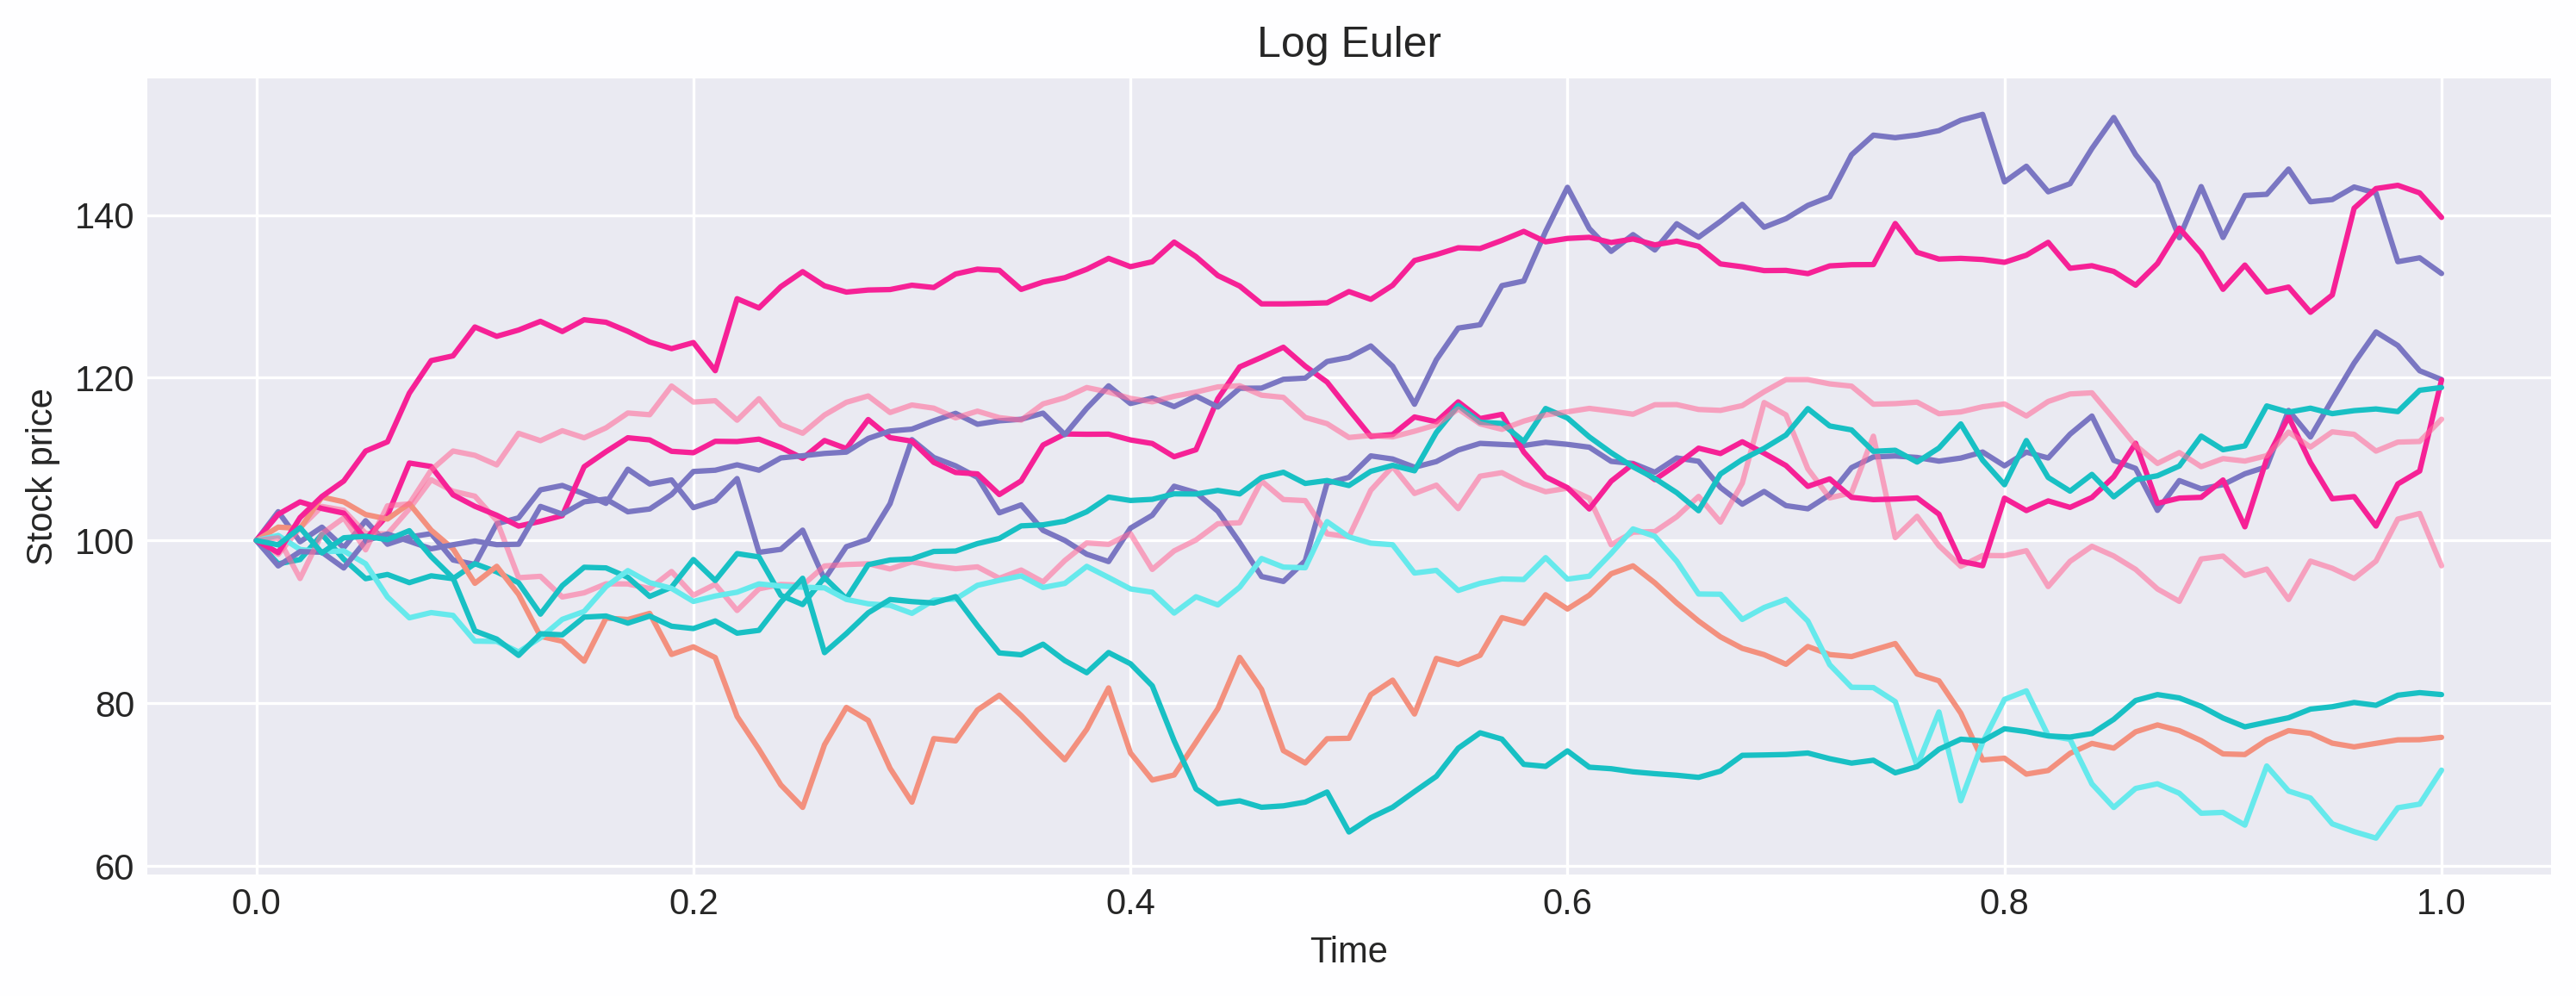

107.12721269161344


In [ ]:
_, ax = plt.subplots(figsize=(12, 4), dpi=300)
ax.plot(np.linspace(ms.time, T, N_STEPS + 1), paths.T)
ax.set_title("Log Euler")
ax.set_xlabel("Time")
ax.set_ylabel("Stock price")
plt.show()
print(np.mean(paths[:, -1]))

In [ ]:
strikes = np.linspace(70, 140, 16)
time = np.array(1.0)

calls = CallStockOption(strike_price=strikes,
                        expiration_time=time)
puts = PutStockOption(strike_price=strikes,
                      expiration_time=time)

ms = MarketState(stock_price=100, interest_rate=0.1)

params = HestonParams(v=0.1, kappa=2, theta=0.1, sigma=0.7, rho=-0.2)

In [ ]:
# Вычисления стоимости опциона методом Моне-Карло

def price_mc(
    option: StockOption,
    ms: MarketState,
    params: HestonParams,
    n_points: int,
):
    T =  np.asarray(option.expiration_time - ms.time)
    N_PATHS = 100000
    N_STEPS = n_points
    print("dt = ", T)


    hs = LogEulerSimulState(params, ms, N_PATHS)

    paths = simulate_heston(
   #     params,
        replace(params, theta=20.0),
        hs,
        time_stop=option.expiration_time,
        n_time_steps=N_STEPS,
        ret_intermediate_states=False, )
    Strikes = np.reshape((option.strike_price), (1, len(option.strike_price)))
    Stock = np.reshape(paths[:, -1], (N_PATHS, 1))

    '''
    paths = heston_euler(N_PATHS, params, T, N_STEPS, ms)
    Strikes = np.reshape((option.strike_price), (1, len(option.strike_price)))
    Stock = np.reshape(paths[-1, :], (N_PATHS, 1))
    '''

    if option.is_call:

      return  np.exp(-T * ms.interest_rate) * np.mean(np.maximum(0, Stock - Strikes), axis=0)

    return  np.exp(-T * ms.interest_rate) * np.mean(np.maximum(0, -Stock + Strikes), axis=0)

dt =  1.0


  0%|          | 0/10000 [00:00<?, ?it/s]

dt =  1.0


  0%|          | 0/10000 [00:00<?, ?it/s]

a =  -3.8164536688579096  b =  3.9164536688579092
 part =  (4095,)
stt =  (4095, 16)
(4095, 16)
a =  -3.8164536688579096  b =  3.9164536688579092
 part =  (4095,)
stt =  (4095, 16)
(4095, 16)


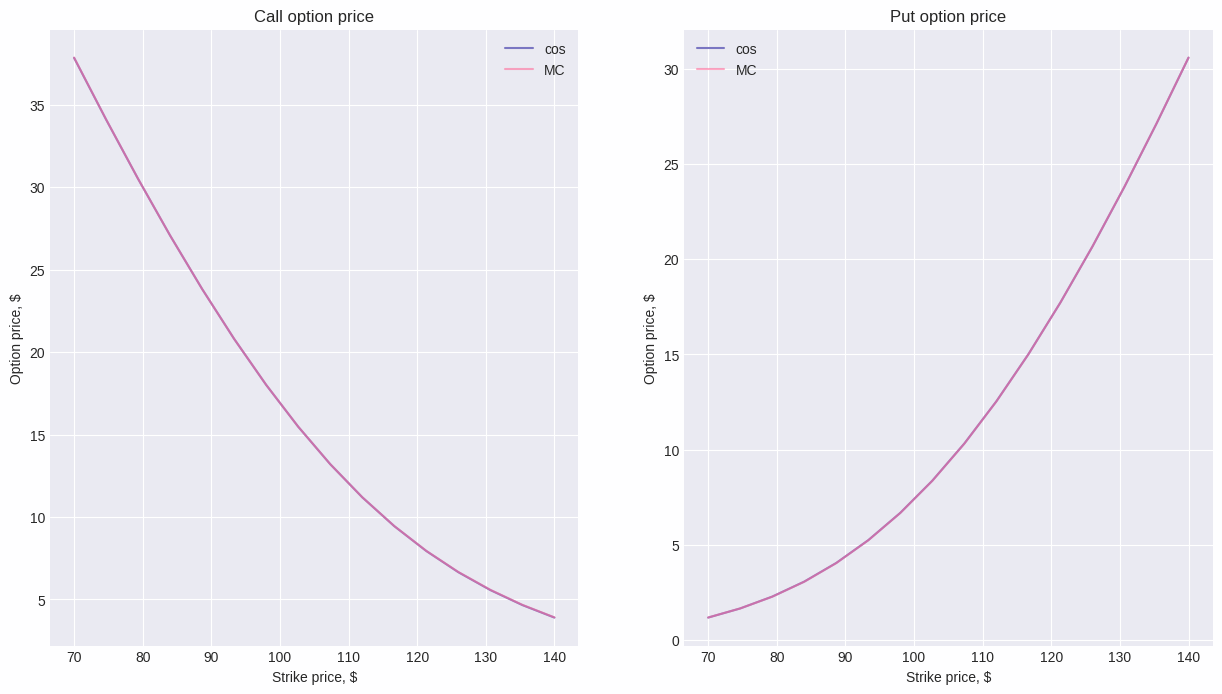

In [ ]:
call_price_mc = price_mc(calls, ms, params, 10000)
put_price_mc = price_mc(puts, ms, params, 10000)
call_price = price(calls, ms, params)
put_price = price(puts, ms, params)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))

ax1.plot(strikes, call_price, label="cos")
ax1.plot(strikes, call_price_mc, label="MC")
ax1.set_title('Call option price')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('Option price, $')
ax1.legend()

ax2.plot(strikes, put_price, label="cos")
ax2.plot(strikes, put_price_mc, label="MC")
ax2.set_title('Put option price')
ax2.set_xlabel('Strike price, $')
ax2.set_ylabel('Option price, $')
ax2.legend()

plt.show()

In [ ]:
def iv(option: StockOption, ms: MarketState, price: Floats):
    assert isinstance(option, (CallStockOption, PutStockOption))

    flag = "c" if isinstance(option, CallStockOption) else "p"
    return implied_volatility_vec(
        price=price,
        S=ms.stock_price,
        K=option.strike_price,
        t=option.expiration_time - ms.time,
        r=ms.interest_rate,
        flag=flag,
    )

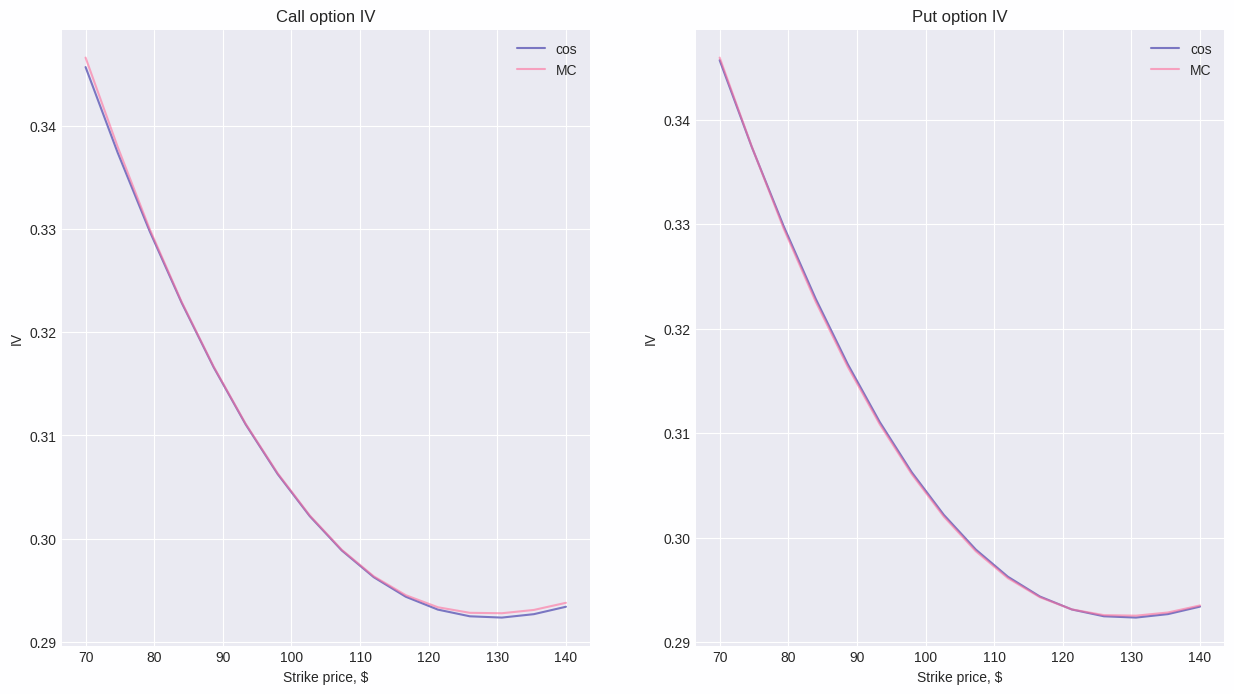

In [ ]:
call_iv = iv(calls, ms, call_price)
put_iv = iv(puts, ms, put_price)
call_iv_mc = iv(calls, ms, call_price_mc)
put_iv_mc = iv(puts, ms, put_price_mc)


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))

ax1.plot(strikes, call_iv, label="cos")
ax1.plot(strikes, call_iv_mc, label="MC")
ax1.set_title('Call option IV')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('IV')
ax1.legend()

ax2.plot(strikes, put_iv, label="cos")
ax2.plot(strikes, put_iv_mc, label="MC")
ax2.set_title('Put option IV')
ax2.set_xlabel('Strike price, $')
ax2.set_ylabel('IV')
ax2.legend()

plt.show()

# Episode 3: the truncatoin range (20 points)

Implement the truncation range choosing algorithm from one of the following papers:
1. [Original paper](https://mpra.ub.uni-muenchen.de/9319/1/MPRA_paper_9319.pdf)
1. [Markov's inequality based](https://www.sciencedirect.com/science/article/pii/S0096300322000212/pdfft?md5=b288c9e0da77d57a61e5a496dffde778&pid=1-s2.0-S0096300322000212-main.pdf)

Use whatever you want: analytical solution, automatic differentiation, automatic code generation, even rust.
Have fun!

In [ ]:
# Из статьи Фанга. [c1 - 12 * sqrt(|c2|), c1 + 12 * sqrt(|c2|)]

def Cumulant_1(params: HestonParams, dt: float):
  return ( ms.interest_rate * dt + (1 - np.exp(-params.kappa * dt)) * (params.theta - params.v)/(2 * params.kappa) - 0.5 * params.theta * dt )

def Cumulant_2(params: HestonParams, dt: float):
  a1 = params.sigma * dt * params.kappa * np.exp(-params.kappa * dt) * (params.v - params.theta) * (8 * params.kappa * params.rho - 4 * params.sigma)
  a2 = params.kappa * params.sigma * params.rho * (1 - np.exp(-params.kappa * dt)) * (16 * params.theta - 8 * params.v)
  a3 = 2 * params.theta * params.kappa * dt * (-4 * params.kappa * params.rho * params.sigma + (params.sigma)**2 + 4 * (params.kappa)**2)
  a4 = ((params.sigma)**2) * ((params.theta - 2 * params.v) * np.exp(-2 * params.kappa * dt) + params.theta * (6 * np.exp(-params.kappa * dt) - 7) + 2 * params.v)
  a5 = 8 * ((params.kappa)**2) * (params.v - params.theta) * (1 - np.exp(-params.kappa * dt))
  return (a1 + a2 + a3 + a4 + a5)/(8 * (params.kappa)**3)



def trunc_range(params: HestonParams, dt: float):
  c1 = Cumulant_1(params, dt)
  c2 = Cumulant_2(params, dt)
  return c1 - 12 * np.sqrt(np.abs(c2)), c1 + 12 * np.sqrt(np.abs(c2))

In [ ]:
#Пример

trunc_range(params, calls.expiration_time - ms.time)

(-3.8164536688579096, 3.9164536688579092)

a =  -3.8664536688579094  b =  3.8664536688579094
 part =  (4095,)
stt =  (4095, 15)
(4095, 15)
a =  -3.8664536688579094  b =  3.8664536688579094
 part =  (4095,)
stt =  (4095, 15)
(4095, 15)


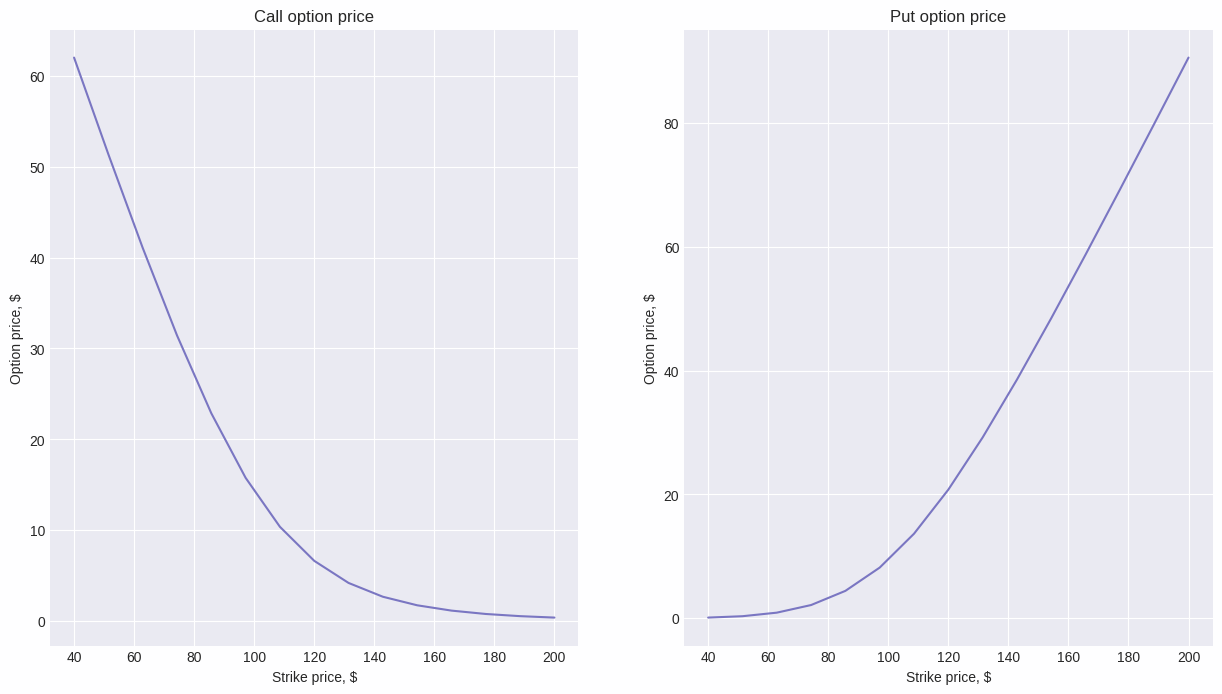

In [ ]:
# Пример вычисления с концами -1000, 1000

def price_(
    option: StockOption,
    ms: MarketState,
    params: HestonParams,
    eps: float = 1e-3,
    n_points: int = 4096,
):
    dt = np.asarray(option.expiration_time - ms.time)
    a, b = -1000, 1000
    print("a = ", a, " b = ", b)
    N = n_points

    sum = Sum(a, b, N, option, params, ms, dt)



    # don't forget to check the argument to be within the truncation bounds

    # assure that the resulting option price strictly greater than the theoretical
    # price lower bound
    put = np.exp(-ms.interest_rate * dt) * sum
    if option.is_call:
      return put + ms.stock_price - option.strike_price * np.exp(-ms.interest_rate * dt)
    return put

strikes = np.linspace(40, 200, 15)
time = np.array(1.0)

calls = CallStockOption(strike_price=strikes,
                        expiration_time=time)
puts = PutStockOption(strike_price=strikes,
                      expiration_time=time)

ms = MarketState(stock_price=100, interest_rate=0.05)

params = HestonParams(v=0.1, kappa=2, theta=0.1, sigma=0.7, rho=-0.2)
call_price = price(calls, ms, params)
put_price = price(puts, ms, params)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))

ax1.plot(strikes, call_price)
ax1.set_title('Call option price')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('Option price, $')
#print(strikes)
ax2.plot(strikes, put_price)
ax2.set_title('Put option price')
ax2.set_xlabel('Strike price, $')
ax2.set_ylabel('Option price, $')

plt.show()

a =  -3.8664536688579094  b =  3.8664536688579094
 part =  (4095,)
stt =  (4095, 15)
(4095, 15)
a =  -3.8664536688579094  b =  3.8664536688579094
 part =  (4095,)
stt =  (4095, 15)
(4095, 15)


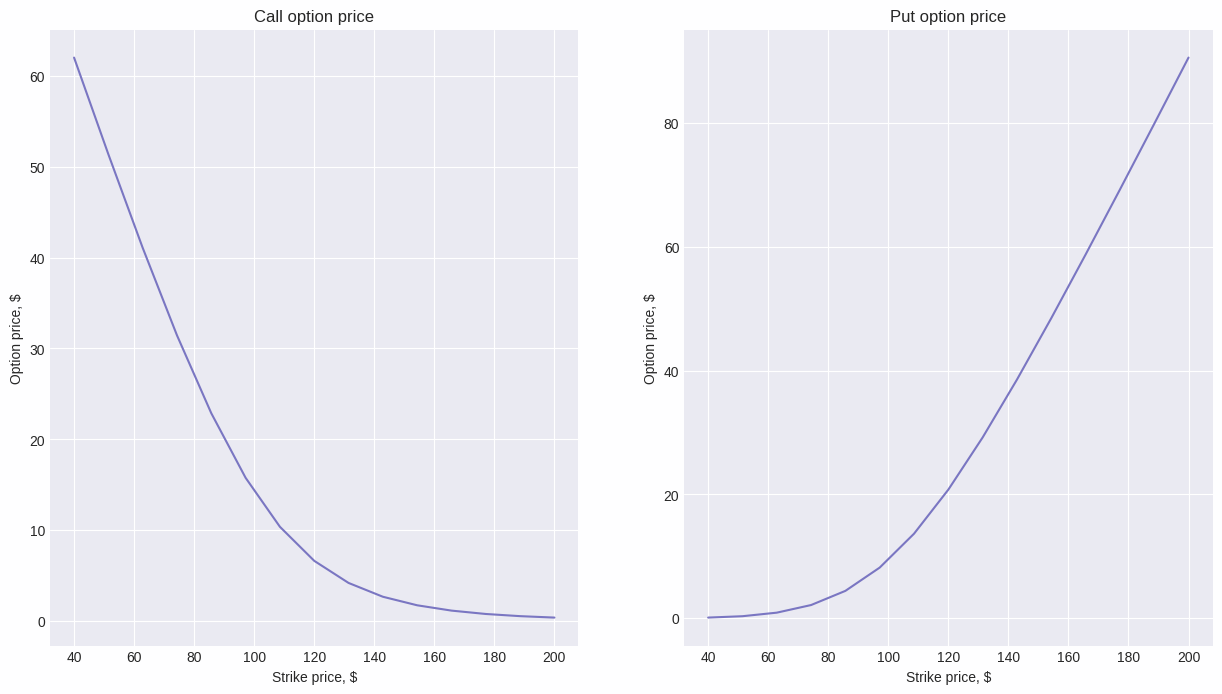

In [ ]:
# Пример с функцией вычисляющая концы по формуле. Вместо -1000, 1000 берем -3.9, 3.9. Намного экономнее, а результат такой же.

def price_(
    option: StockOption,
    ms: MarketState,
    params: HestonParams,
    eps: float = 1e-3,
    n_points: int = 4096,
):
    dt = np.asarray(option.expiration_time - ms.time)
    a, b = trunc_range(params, dt)
    print("a = ", a, " b = ", b)
    N = n_points

    sum = Sum(a, b, N, option, params, ms, dt)



    # don't forget to check the argument to be within the truncation bounds

    # assure that the resulting option price strictly greater than the theoretical
    # price lower bound
    put = np.exp(-ms.interest_rate * dt) * sum
    if option.is_call:
      return put + ms.stock_price - option.strike_price * np.exp(-ms.interest_rate * dt)
    return put

strikes = np.linspace(40, 200, 15)
time = np.array(1.0)

calls = CallStockOption(strike_price=strikes,
                        expiration_time=time)
puts = PutStockOption(strike_price=strikes,
                      expiration_time=time)

ms = MarketState(stock_price=100, interest_rate=0.05)

params = HestonParams(v=0.1, kappa=2, theta=0.1, sigma=0.7, rho=-0.2)
call_price = price(calls, ms, params)
put_price = price(puts, ms, params)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))

ax1.plot(strikes, call_price)
ax1.set_title('Call option price')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('Option price, $')
#print(strikes)
ax2.plot(strikes, put_price)
ax2.set_title('Put option price')
ax2.set_xlabel('Strike price, $')
ax2.set_ylabel('Option price, $')

plt.show()

# Episode 4: Memes (10 points) 🤡

Come up with a funny financial math meme.
If the meme is not funny, then we will have to deduct points.
Don't steal memes, come up with your own!

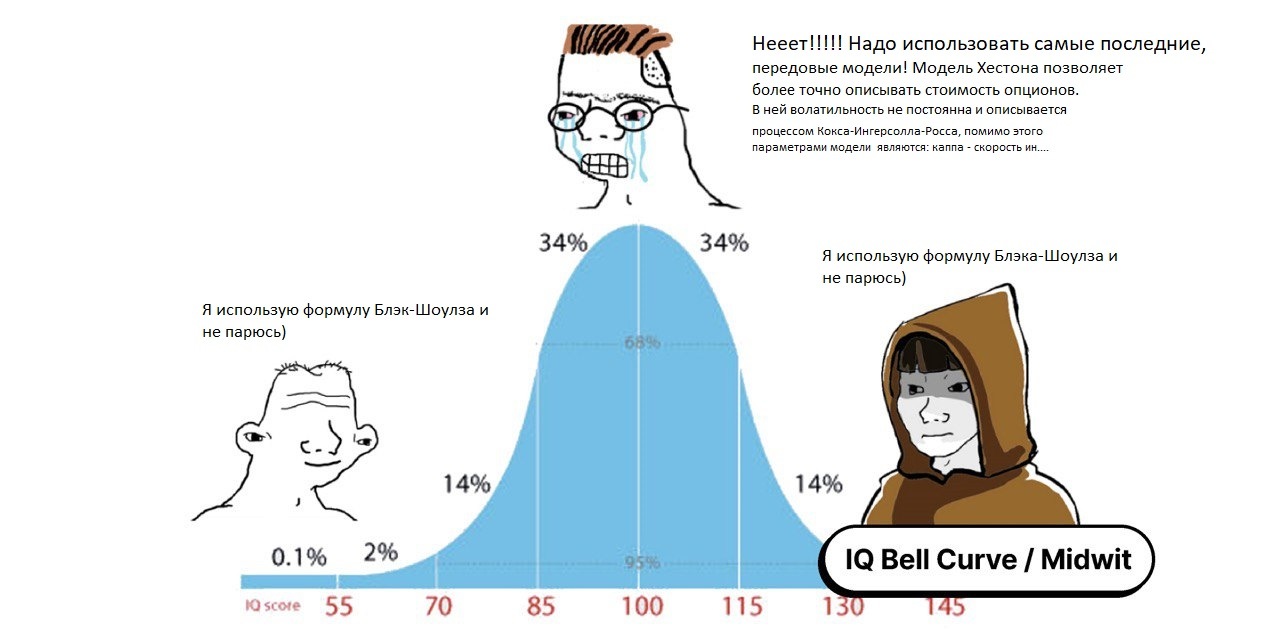

In [ ]:
from IPython.display import Image
Image(filename='LabM.jpg')